# Fraud Detection in Electricity and Gas Consumption Challenge

This is a simple starter notebook based on the tutorial prepared by Joy Wawira. Check out the article [here](https://zindi.africa/learn/fraud-detection-in-electricity-and-gas-consumption-challenge-tutorial) for a more detailed description of the steps taken.

This notebook covers:
- Downloading the data straight from Zindi and onto colab
- Loading the data and carrying out simple EDA to understand the data and prepare for modelling 
- Preprocessing the data and feature engineering 
- Creating a simple LGBM model and predicting on the test set
- Prepare submission file and save as csv
- Some tips on how to improve model performance and your score

Client dataset columns:

- Client_id: Unique id for client
- District: District where the client is
- Client_catg: Category client belongs to
- Region: Area where the client is
- Creation_date: Date client joined
- Target: fraud:1 , not fraud: 0


Invoice data

- Client_id: Unique id for the client
- Invoice_date: Date of the invoice
- Tarif_type: Type of tax
- Counter_number: the meter's ID
- Counter_statue: takes up to 5 values such as working fine, not working, on hold statue, ect
- Counter_code:
- Reading_remarque: notes that the STEG agent takes during his visit to the client (e.g: If the counter shows something wrong, the agent gives a bad score)
- Counter_coefficient: An additional coefficient to be added when standard consumption is exceeded
- Consommation_level_1: consuption bracket 1
- Consommation_level_2: consuption bracket 2
- Consommation_level_3: consuption bracket 3
- Consommation_level_4: consuption bracket 4
- Old_index: Old index
- New_index: New index
- Months_number: time since last reading, in months
- Counter_type: Type of counter, whether is electricity (ELEC) meter or gas (GAZ) meter, later we shall encode it as `{ELEC : 0, GAZ : 1}`

# Libraries set up

In [1]:
#libraries for data handling and EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#libraries for modelling
from sklearn.preprocessing import StandardScaler
from sklearn.impute import (
    SimpleImputer, 
    KNNImputer)
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
    PolynomialFeatures,
    KBinsDiscretizer
)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


#hide warnings
import warnings
warnings.simplefilter('ignore')

# Data Preparation

**import the data into a dataframe**

In [2]:
client = pd.read_csv('data/client_train.csv')
invoice = pd.read_csv('data/invoice_train.csv')

**brief data exploration**

In [3]:
#compare size of the two datasets
print('client dataset:', client.shape)
print('invoice dataset', invoice.shape)

client dataset: (135493, 6)
invoice dataset (4476749, 16)


We have a number of invoices per client.

In [4]:
#display the client dataset
client.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [5]:
#display the invoice dataset
invoice.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [6]:
#info about the client dataset
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [7]:
#info about the client dataset
invoice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


**checking for missing values in the datasets**

In [8]:
#check for missing values in client
client.isnull().sum()

disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64

In [9]:
#check for missing values i ninvoice
invoice.isnull().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

There are no missing values in the datasets.

We now check where we can find zeros in the dataset as they can be a sign of missing data in columns like `invoice_date` or `counter_number`.

In [10]:
#Counting zeros in the client data
for col in client.columns:
    print(f"{col} - {client[client[col] == 0.][col].size}")

disrict - 0
client_id - 0
client_catg - 0
region - 0
creation_date - 0
target - 127927


The client datase does not show presence of zeros da could hide missing values.

In [11]:
#Counting zeros in the invoice data
for col in invoice.columns:
    print(f"{col} - {invoice[invoice[col] == 0.][col].size}")

client_id - 0
invoice_date - 0
tarif_type - 0
counter_number - 43161
counter_statue - 4346960
counter_code - 33
reading_remarque - 0
counter_coefficient - 46
consommation_level_1 - 467553
consommation_level_2 - 3816179
consommation_level_3 - 4293391
consommation_level_4 - 4383791
old_index - 287906
new_index - 195931
months_number - 2
counter_type - 0


The presence of zeros in `counter_number`, `counter_code`, `old_index`, `new_index` and `months_number` could be hiding missing values. We might have to return to these columns later on, depending on what features are more relevant do determine is a observation corresponds to fraud or not. 

**diplay number of unique values in each column**

In [12]:
#Count unique values on the client dataset
for col in client.columns:
    print(f"{col} - {client[col].nunique()}")

disrict - 4
client_id - 135493
client_catg - 3
region - 25
creation_date - 8088
target - 2


The number of unique values in the client dataset seems to make sense.

In [13]:
#Count unique values on the invoice dataset
for col in invoice.columns:
    print(f"{col} - {invoice[col].nunique()}")

client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 16
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


- We have the same number of clients in invoice dataset as in the client dataset. 
- `client_catg` in the client dataset is not clearly related to the tarif type in the invoice dataset.
- `counter_statue` is of the `object` type and has 16 unique values, even though it corresponds to a numerical integer grade from 0 to 5.
- The high number of unique values in `months_number` seems to indicate that some readings are very spaced in time.

**data cleaning**

The `target` column in client is of the float type. We will change it to int.

In [14]:
client['target'] = client['target'].astype('int64') 

The `creation_date` in client and `invoice_date` in invoice are not of the date type and we shall encode them as such.

In [15]:
client['creation_date'] = pd.to_datetime(client['creation_date'], format = '%d/%m/%Y')
invoice['invoice_date'] = pd.to_datetime(invoice['invoice_date'])

The `counter_statue` display more unique values than it should have and is not of the numerical type.

In [16]:
#display unique values in counter_statue column of invoice 
pd.unique(invoice['counter_statue'])

array([0, 1, 5, 4, 3, 2, 769, '0', '5', '1', '4', 'A', 618, 269375, 46,
       420], dtype=object)

It is a mix of numbers and strings from 0 to 5 and numbers and letters that do not fit in that grade scale.

In [17]:
#count the number of occurences of each unique value in counter_statue
pd.value_counts(invoice['counter_statue'])

counter_statue
0         4346960
1           73496
0           32048
5           20495
4            2706
1             540
3             258
5             144
2              32
4              23
46             14
A              13
618            12
769             6
269375          1
420             1
Name: count, dtype: int64

In [18]:
anomalies_counter_statue = [769, 'A', 618, 269375, 46, 420]
print('Number of non-frauds:', client[client['target']==0].size)
print('Number of frauds:', client[client['target']==1].size)
print('Number of anomalous entries in counter_statue:', invoice[invoice['counter_statue'].isin(anomalies_counter_statue)].groupby('client_id').size().sum())

Number of non-frauds: 767562
Number of frauds: 45396
Number of anomalous entries in counter_statue: 47


Hence the number of anomalies in `counter_statue` is small enough to be dropped without affecting much the dataset. Before dropping these anomalies, let us first check if they are related to fraud cases.

In [19]:
aux_df = invoice[invoice['counter_statue'].isin(anomalies_counter_statue)].groupby('client_id', as_index = False).size()['client_id']
client.merge(aux_df, left_on='client_id', right_on='client_id')

,disrict,client_id,client_catg,region,creation_date,target
0,62,train_Client_13203,11,301,2010-01-04,0
1,60,train_Client_30467,11,101,1979-05-21,0
2,63,train_Client_47780,11,306,2015-05-08,0
3,60,train_Client_53725,11,101,1982-11-15,0
4,62,train_Client_78338,11,304,1980-10-13,0
5,69,train_Client_79075,11,107,2011-11-28,0


So there are not any relation between these anomalies and fraud cases and we shall dop then.

In [20]:
#screen the invoice dataframe for the rows whose counter_statue cell does not assume an anomalous value. 
invoice = invoice[~invoice['counter_statue'].isin(anomalies_counter_statue)]

In [21]:
#chage the tye os the numbers coded as strings to int64
invoice['counter_statue'] = invoice['counter_statue'].astype('int64')

In [22]:
#display current unique values
pd.unique(invoice['counter_statue'])

array([0, 1, 5, 4, 3, 2], dtype=int64)

**data formatting and merge of the datasets**

In [23]:
#formatting the client dataset column names
client.rename(columns = {'target' : 'fraud', 'disrict' : 'district'}, inplace = True)
#remove day of the month for when the contract was created
client['creation_date'] = client['creation_date'].apply(lambda x: x.strftime('%Y-%m'))

In [24]:
#write the formatted client dataset into a file 
client.to_csv('data/client_formatted.csv', index = False)

In [25]:
#formatting the client dataset column names
invoice.rename(columns = {'counter_number' : 'meter_id', 
                 'counter_statue' : 'meter_state', 'counter_code' : 'meter_code', 
                 'reading_remarque' : 'reading_remark', 'counter_coefficient' : 'meter_coeff', 
                 'consommation_level_1' : 'consum_band_1','consommation_level_2' : 'consum_band_2',
                 'consommation_level_3' : 'consum_band_3', 'consommation_level_4' : 'consum_band_4', 
                 'months_number' : 'months_since_last_reading', 'counter_type' : 'meter_type'}, inplace = True)
#encode the meter_type classes 
invoice['meter_type'] = invoice['meter_type'].map({'ELEC' : 0, 'GAZ' : 1})
#remove day of the moth from invoice_date
invoice['invoice_date'] = invoice['invoice_date'].apply(lambda x: x.strftime('%Y-%m'))

In [26]:
#write the formatted invoice dataset into a file 
invoice.to_csv('data/invoice_formatted.csv', index = False)

We merge both datasets on `client_id`

In [27]:
#we merge the two datasets
invoice_client_merge_df = pd.merge(invoice, client, left_on='client_id', right_on='client_id')
invoice_client_merge_df.head()

,client_id,invoice_date,tarif_type,meter_id,meter_state,meter_code,reading_remark,meter_coeff,consum_band_1,consum_band_2,...,consum_band_4,old_index,new_index,months_since_last_reading,meter_type,district,client_catg,region,creation_date,fraud
0,train_Client_0,2014-03,11,1335667,0,203,8,1,82,0,...,0,14302,14384,4,0,60,11,101,1994-12,0
1,train_Client_0,2013-03,11,1335667,0,203,6,1,1200,184,...,0,12294,13678,4,0,60,11,101,1994-12,0
2,train_Client_0,2015-03,11,1335667,0,203,8,1,123,0,...,0,14624,14747,4,0,60,11,101,1994-12,0
3,train_Client_0,2015-07,11,1335667,0,207,8,1,102,0,...,0,14747,14849,4,0,60,11,101,1994-12,0
4,train_Client_0,2016-11,11,1335667,0,207,9,1,572,0,...,0,15066,15638,12,0,60,11,101,1994-12,0


In [28]:
#write the merged dataset into a file 
invoice_client_merge_df.to_csv('data/invoice_client_merge.csv', index = False)

In [29]:
#separate the dataframes in farud and normal occurences
normal_df = invoice_client_merge_df[invoice_client_merge_df['fraud'] == 0].drop(columns = 'fraud')
fraud_df = invoice_client_merge_df[invoice_client_merge_df['fraud'] == 1].drop(columns = 'fraud')

In [30]:
#write the normal and fraud occurences dataset into files 
normal_df.to_csv('data/normal_occurences.csv', index = False)
fraud_df.to_csv('data/fraud_occurences.csv', index = False)

# EDA

In [54]:
#load the prepared data
client = pd.read_csv('data/client_formatted.csv')
invoice = pd.read_csv('data/invoice_formatted.csv')
fraud_df = pd.read_csv('data/fraud_occurences.csv')
normal_df = pd.read_csv('data/normal_occurences.csv')
invoice_client_merge = pd.read_csv('data/invoice_client_merge.csv')

## Sample balance

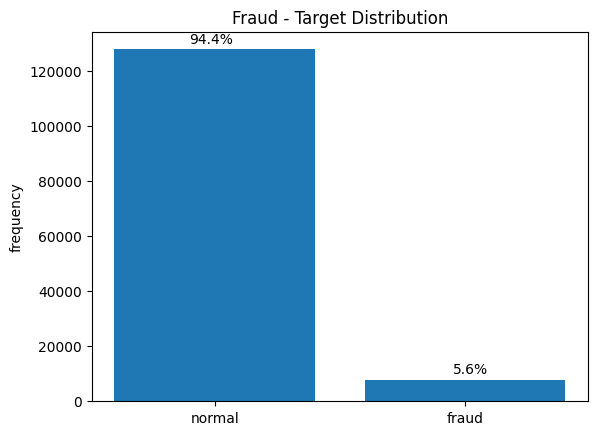

In [31]:
p0, p1 = (pd.value_counts(client['fraud'], normalize=True)*100).round(1)
#Visualize fraudulent activities
fraudactivities = client.groupby(['fraud'])['client_id'].count()
plt.bar(x=fraudactivities.index, height=fraudactivities.values, tick_label = ['normal','fraud'])
plt.ylabel('frequency')
plt.title('Fraud - Target Distribution')
plt.text(x=-.1,y=130000,s=f'{p0}%')
plt.text(x=0.95,y=10000,s=f'{p1}%')
plt.show()

Target is highly imbalanced with fewer cases of fraudulent activities. Fraud is a rare event so that is expected.

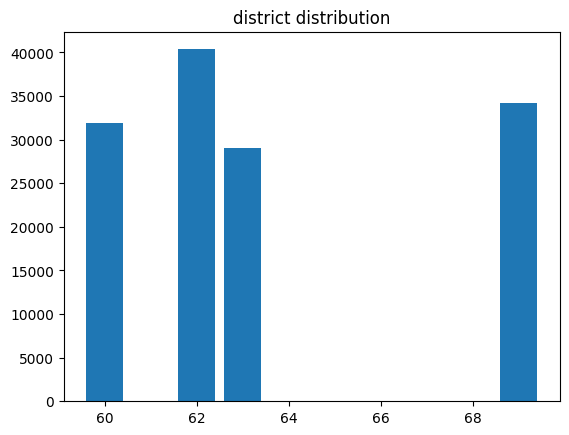

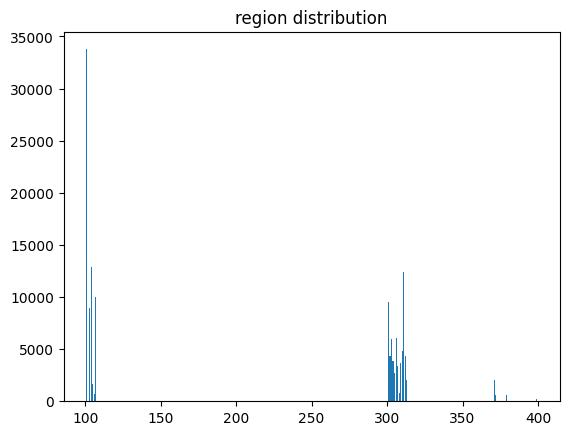

In [32]:
#Visualize client distribution across districts and regions
for col in ['district','region']:
    region = client.groupby([col])['client_id'].count()
    plt.bar(x=region.index, height=region.values)
    plt.title(col+' distribution')
    plt.show()

The sample is no too imbalanced with respect to the distribution in `distric`, but it is clearly imbalanced in the distribution in `region`.

We now check the balance of the electricity and gas readings.

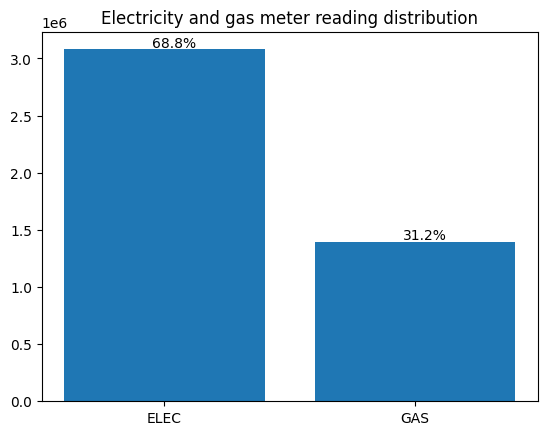

In [33]:
#Visualize fraudulent activities
elec_gas_readings = invoice.groupby(['meter_type'])['meter_type'].size()
r0, r1 = (pd.value_counts(invoice['meter_type'], normalize=True)*100).round(1)
plt.bar(x=elec_gas_readings.index, height=elec_gas_readings.values, tick_label = ['ELEC', 'GAS'])
plt.title('Electricity and gas meter reading distribution')
plt.text(x=-.05,y=3100000,s=f'{r0}%')
plt.text(x=0.95,y=1420000,s=f'{r1}%')
plt.show()

The samples are also imbalanced with respect to gas and electricity readings, gas readings are less than halh of the electricity readings.

## EDA Hypothesis

- A: Fraudulent comsumption pattern presents more variance over time.
- B: Electricity consumption is more prone to show fraud than gas, as it is tecnically simpler to steal electricity than gas.
- C: Fraud occurences involve higher comsumption of energy.
- D: The more spaced the readings the more likely its to have fraud.
- E: Meters in poorer conditions are more prone to fraud.

## EDA on consumption partterns

**comsumption time series**

Let us randomly select two clients, one a fraudist and the other a normal client.

In [34]:
import random
n_clients_0, n_clients_1 = pd.value_counts(client['fraud'])
ratio = 0.
meter_type = 0 #ELEC : 0, GAS : 1
while (ratio < 0.95):
    client_id_fraud = client[client['fraud']==0].reset_index()['client_id'][random.randrange(n_clients_0)]
    client_id_normal = client[client['fraud']==1].reset_index()['client_id'][random.randrange(n_clients_1)]
    readings_n = invoice[(invoice['client_id'] == client_id_normal) & (invoice['meter_type'] == meter_type)].shape[0]
    readings_f = invoice[(invoice['client_id'] == client_id_fraud) & (invoice['meter_type'] == meter_type)].shape[0]
    if readings_n >= readings_f: 
        ratio = readings_n and readings_f/readings_n or 0
    else:
        ratio = readings_f and readings_n/readings_f or 0
        
print(client_id_fraud, invoice[(invoice['client_id'] == client_id_fraud) & (invoice['meter_type'] == meter_type)].shape[0])
print(client_id_normal, invoice[(invoice['client_id'] == client_id_normal) & (invoice['meter_type'] == meter_type)].shape[0])

train_Client_68489 41
train_Client_48759 41


In [35]:
time_series_feats = ['invoice_date', 'consum_band_1', 'consum_band_2', 'consum_band_3', 'consum_band_4']

consum_time_series_normal = invoice[(invoice['client_id'] == client_id_normal) & 
                                    (invoice['meter_type'] == meter_type)][time_series_feats].sort_values(by = 'invoice_date').reset_index(drop = True)
consum_time_series_normal['invoice_date'] = pd.to_datetime(consum_time_series_normal['invoice_date']).apply(lambda x: x.strftime('%Y-%m'))

consum_time_series_fraud = invoice[(invoice['client_id'] == client_id_fraud) & 
                                   (invoice['meter_type'] == meter_type)][time_series_feats].sort_values(by = 'invoice_date').reset_index(drop = True)
consum_time_series_fraud['invoice_date'] = pd.to_datetime(consum_time_series_fraud['invoice_date']).apply(lambda x: x.strftime('%Y-%m'))

av_consum_time_series = invoice[invoice['meter_type'] == meter_type].groupby('invoice_date', as_index = False)[time_series_feats[1:]].mean()

In [36]:
consum_time_series_normal.head()

,invoice_date,consum_band_1,consum_band_2,consum_band_3,consum_band_4
0,2006-08,119,0,0,0
1,2006-08,99,0,0,0
2,2007-03,215,0,0,0
3,2007-07,647,0,0,0
4,2007-08,1086,0,0,0


In [37]:
consum_time_series_fraud.head()

,invoice_date,consum_band_1,consum_band_2,consum_band_3,consum_band_4
0,2005-11,397,0,0,0
1,2006-04,476,0,0,0
2,2006-08,434,0,0,0
3,2006-12,455,0,0,0
4,2007-04,507,0,0,0


In [38]:
av_consum_time_series.head()

,invoice_date,consum_band_1,consum_band_2,consum_band_3,consum_band_4
0,1977-06,15.500000,0.0,0.0,0.0
1,1977-08,153.500000,0.0,0.0,0.0
2,1977-11,61.000000,0.0,0.0,0.0
3,1977-12,210.666667,0.0,0.0,0.0
4,1978-01,278.000000,0.0,0.0,0.0


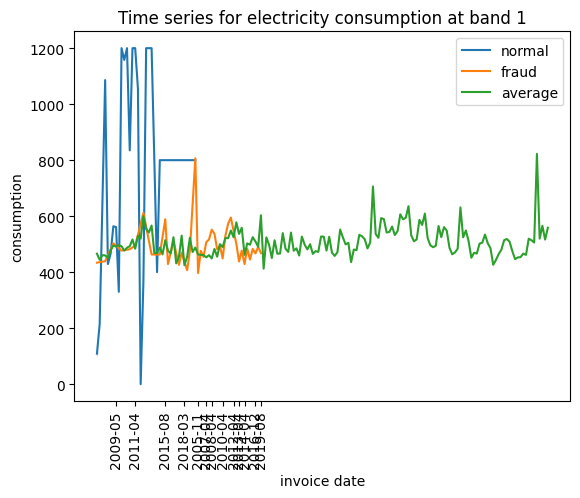

In [39]:
x1 = consum_time_series_normal['invoice_date'].to_list()
x2 = consum_time_series_fraud['invoice_date'].to_list()
x = sorted(list(set(x1 + x2)))
band = 'consum_band_1'

x_min = x[0]
x_max = x[-1]

av_consum_time_series = av_consum_time_series[av_consum_time_series['invoice_date'].between(x_min,x_max)]

sns.lineplot(data = consum_time_series_normal, x = 'invoice_date', y = band, label = 'normal')
sns.lineplot(data = consum_time_series_fraud, x = 'invoice_date', y = band, label = 'fraud')
sns.lineplot(data = av_consum_time_series, x = 'invoice_date', y = band, label = 'average')
plt.xticks(ticks = x[::5],  rotation='vertical')
plt.xlabel('invoice date')
plt.ylabel('consumption')
plt.title('Time series for electricity consumption at band 1')
plt.show()

Let us take a look at the variance of the consumption at each band. 

In [74]:
bands = ['consum_band_1', 'consum_band_2', 'consum_band_3', 'consum_band_4']

consum_var_normal = normal_df.groupby(['client_id', 'meter_type'], as_index = False)[bands].var().dropna()
consum_var_fraud = fraud_df.groupby(['client_id', 'meter_type'], as_index = False)[bands].var().dropna()

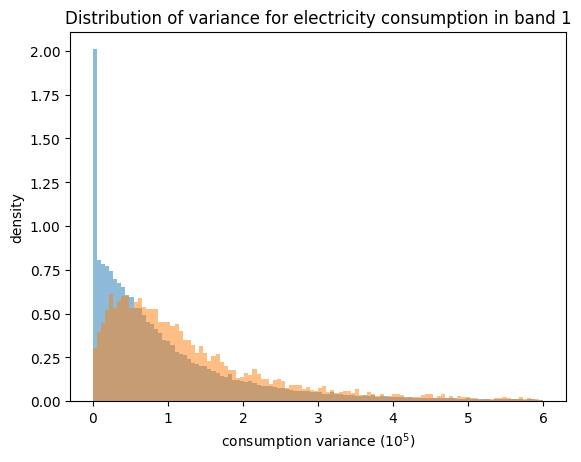

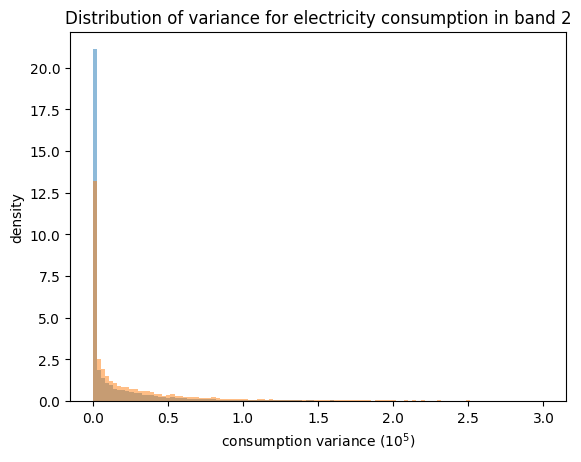

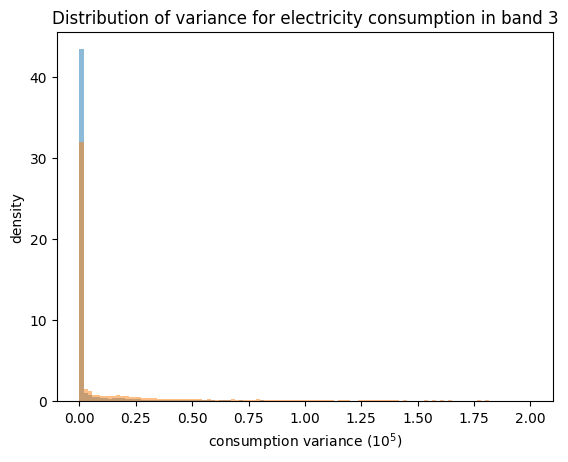

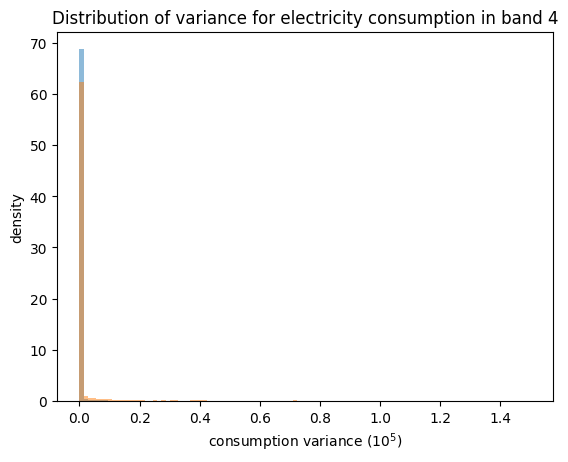

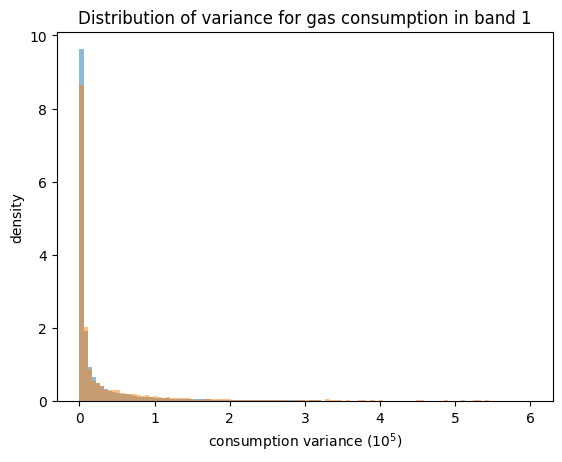

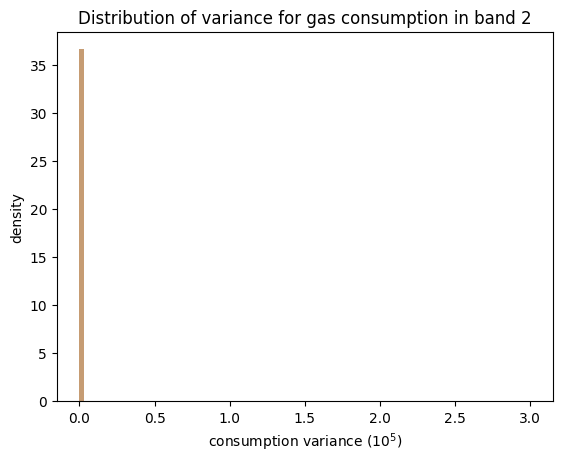

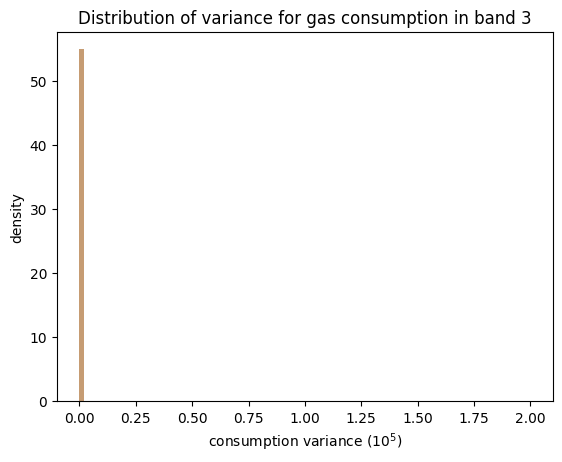

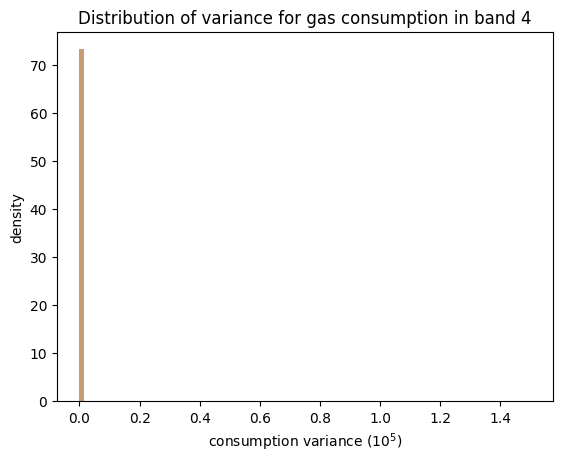

In [75]:

for i, band in enumerate(bands):
    plt.hist(consum_var_normal[consum_var_normal['meter_type'] == 0][band]/100000, bins = 110, range = (0,6/(i+1)), density = True, alpha = 0.5)
    plt.hist(consum_var_fraud[consum_var_fraud['meter_type'] == 0][band]/100000, bins = 110, range = (0,6/(i+1)), density = True, alpha = 0.5)
    plt.ylabel('density')
    plt.xlabel('consumption variance ($10^5$)')
    plt.title(f'Distribution of variance for electricity consumption in band {i+1}')
    plt.show()
    
for i, band in enumerate(bands):
    plt.hist(consum_var_normal[consum_var_normal['meter_type'] == 1][band]/100000, bins = 110, range = (0,6/(i+1)), density = True, alpha = 0.5)
    plt.hist(consum_var_fraud[consum_var_fraud['meter_type'] == 1][band]/100000, bins = 110, range = (0,6/(i+1)), density = True, alpha = 0.5)
    plt.ylabel('density')
    plt.xlabel('consumption variance ($10^5$)')
    plt.title(f'Distribution of variance for gas consumption in band {i+1}')
    plt.show()

Hence, fraud occurences have higher consumption variance at the electricity consumption band 1. 

**total consumption accross bands**

Create a new feature for the total consumption accross bands.

In [76]:
normal_df['reading_total_consum'] = normal_df['consum_band_1'] + normal_df['consum_band_2'] + normal_df['consum_band_3'] + normal_df['consum_band_4']
fraud_df['reading_total_consum'] = fraud_df['consum_band_1'] + fraud_df['consum_band_2'] + fraud_df['consum_band_3'] + fraud_df['consum_band_4']

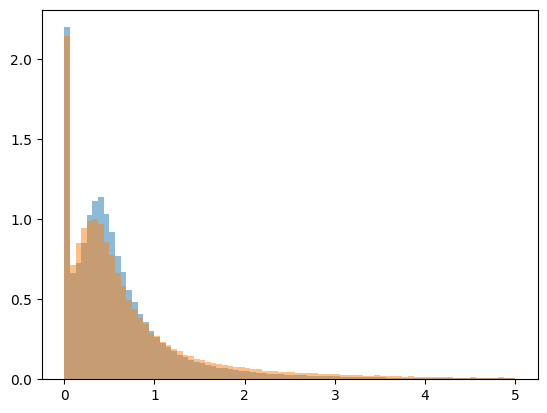

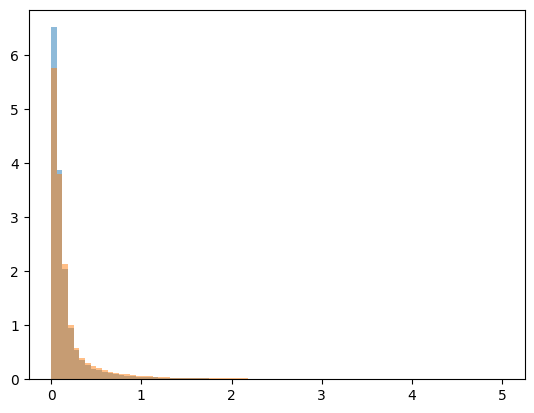

In [77]:
plt.hist(normal_df[normal_df['meter_type'] == 0]['reading_total_consum']/1000, bins = 80, range = (0,5), density = True, alpha = 0.5)
plt.hist(fraud_df[fraud_df['meter_type'] == 0]['reading_total_consum']/1000, bins = 80, range = (0,5), density = True, alpha = 0.5)
plt.show()

plt.hist(normal_df[normal_df['meter_type'] == 1]['reading_total_consum']/1000, bins = 80, range = (0,5), density = True, alpha = 0.5)
plt.hist(fraud_df[fraud_df['meter_type'] == 1]['reading_total_consum']/1000, bins = 80, range = (0,5), density = True, alpha = 0.5)
plt.show()

We see the distribution for total energy consumption is different for electricity and gas but there is no difference between fraud and normal occurences for each type.

## EDA on reading patterns

We check the distribution of total number of months since last reading

In [44]:
total_consum_normal = normal_df.groupby(['client_id', 'meter_type'], as_index = False).aggregate({'consum_band_1' : 'sum', 'consum_band_2' : 'sum', 
                                                                                                'consum_band_3' : 'sum', 'consum_band_4' : 'sum',
                                                                                                'reading_total_consum' : 'sum', 
                                                                                                'months_since_last_reading' : 'sum', 'client_id': 'size'})
total_consum_normal.rename(columns = {'consum_band_1' : 'tot_consum_band_1', 
                           'consum_band_2' : 'tot_consum_band_1', 
                           'consum_band_3' : 'tot_consum_band_1', 
                           'consum_band_4' : 'tot_consum_band_1', 
                           'reading_total_consum' : 'tot_consum', 
                           'months_since_last_reading' : 'tot_months', 
                           'client_id': 'tot_readings'}, inplace = True)
total_consum_normal.head()

,meter_type,tot_consum_band_1,tot_consum_band_1,tot_consum_band_1,tot_consum_band_1,tot_consum,tot_months,tot_readings
0,0,12334,370,0,0,12704,162,35
1,0,20629,0,0,0,20629,160,37
2,0,14375,682,0,0,15057,116,18
3,0,24,0,0,0,24,84,20
4,0,9292,1468,1643,514,12917,52,14


In [45]:
total_consum_fraud = fraud_df.groupby(['client_id', 'meter_type'], as_index = False).aggregate({'consum_band_1' : 'sum', 'consum_band_2' : 'sum', 
                                                                                                'consum_band_3' : 'sum', 'consum_band_4' : 'sum',
                                                                                                'reading_total_consum' : 'sum', 
                                                                                                'months_since_last_reading' : 'sum', 'client_id': 'size'})
total_consum_fraud.rename(columns = {'consum_band_1' : 'tot_consum_band_1', 
                           'consum_band_2' : 'tot_consum_band_1', 
                           'consum_band_3' : 'tot_consum_band_1', 
                           'consum_band_4' : 'tot_consum_band_1', 
                           'reading_total_consum' : 'tot_consum', 
                           'months_since_last_reading' : 'tot_months', 
                           'client_id': 'tot_readings'}, inplace = True)
total_consum_fraud.head()

,meter_type,tot_consum_band_1,tot_consum_band_1,tot_consum_band_1,tot_consum_band_1,tot_consum,tot_months,tot_readings
0,0,7066,0,0,0,7066,80,18
1,0,21041,1633,592,0,23266,110,23
2,0,14693,706,68,0,15467,122,26
3,1,2163,0,0,0,2163,130,30
4,0,9575,0,0,0,9575,98,24


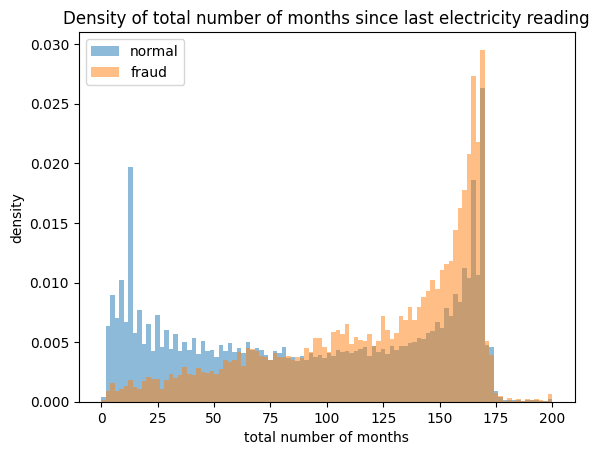

In [46]:
plt.title('Density of total number of months since last electricity reading')
plt.hist(total_consum_normal[total_consum_normal['meter_type'] == 0]['tot_months'], density = True, bins = 100, range = (0, 200), label = 'normal', alpha = 0.5)
plt.hist(total_consum_fraud[total_consum_fraud['meter_type'] == 0]['tot_months'], density = True, bins = 100, range = (0, 200), label = 'fraud', alpha = 0.5)
plt.ylabel('density')
plt.xlabel('total number of months')
plt.legend()
plt.show()

There is a clear distinction between fraud and normal occurences signaling that on average the total number of months since last **electricity** reading is higher for fraud occurences.

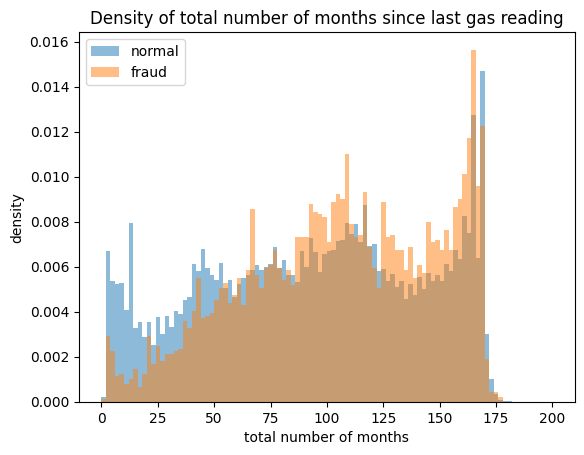

In [47]:
plt.title('Density of total number of months since last gas reading')
plt.hist(total_consum_normal[total_consum_normal['meter_type'] == 1]['tot_months'], density = True, bins = 100, range = (0, 200), label = 'normal', alpha = 0.5)
plt.hist(total_consum_fraud[total_consum_fraud['meter_type'] == 1]['tot_months'], density = True, bins = 100, range = (0, 200), label = 'fraud', alpha = 0.5)
plt.ylabel('density')
plt.xlabel('total number of months')
plt.legend()
plt.show()

There is no clear distinction between fraud and normal occurences for the total number of months since last **gas** reading.

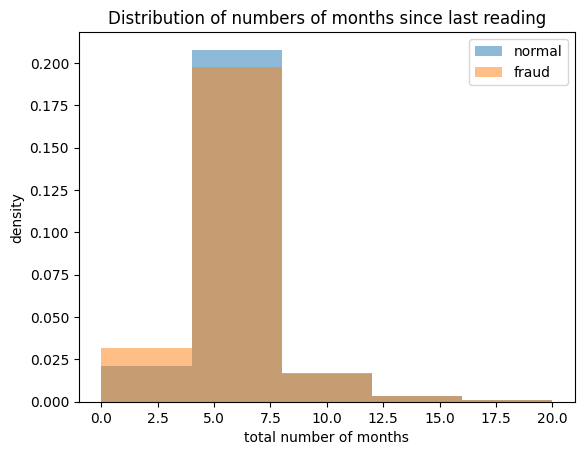

In [48]:
plt.title('Distribution of numbers of months since last reading')
plt.hist(normal_df[normal_df['meter_type'] == 0]['months_since_last_reading'], density = True, bins = 5, range = (0, 20), label = 'normal', alpha = 0.5)
plt.hist(fraud_df[fraud_df['meter_type'] == 0]['months_since_last_reading'], density = True, bins = 5, range = (0, 20), label = 'fraud', alpha = 0.5)
plt.ylabel('density')
plt.xlabel('total number of months')
plt.legend()
plt.show()

The distribution of the number of months since last electricity reading for fraud and normal occurence are very similar. We have also check that this is the case for gas reading and electricity and gas combined. 

We now compute the number of readings for each client and compute the mean time since last reading.

In [49]:
#compute mean time since last reading
total_consum_normal['mean_time_between_readings'] = total_consum_normal['tot_months']/total_consum_normal['tot_readings']
total_consum_fraud['mean_time_between_readings'] = total_consum_fraud['tot_months']/total_consum_fraud['tot_readings']

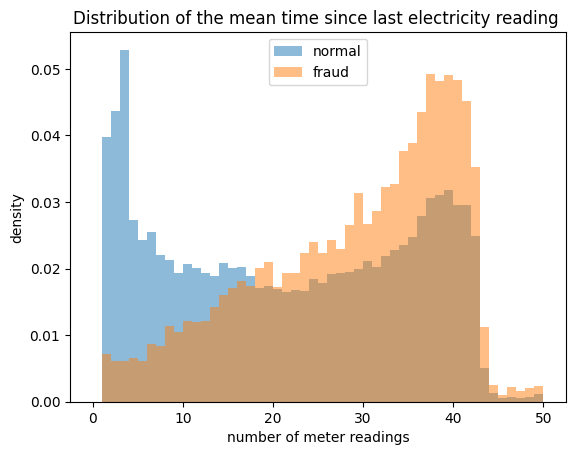

In [50]:
plt.title('Distribution of the mean time since last electricity reading ')
plt.hist(total_consum_normal[total_consum_normal['meter_type'] == 0]['tot_readings'], density = True, bins = 50, range = (0, 50), label = 'normal', alpha = 0.5)
plt.hist(total_consum_fraud[total_consum_fraud['meter_type'] == 0]['tot_readings'], density = True, bins = 50, range = (0, 50), label = 'fraud', alpha = 0.5)
plt.ylabel('density')
plt.xlabel('number of meter readings')
plt.legend()
plt.show()

This distribution has a very similar shape as the distribution for the total number of months since last electricity reading. Hence this two dsitribution only show that a fraud occurence is more likely to be detected if the household is inspected several times over time.

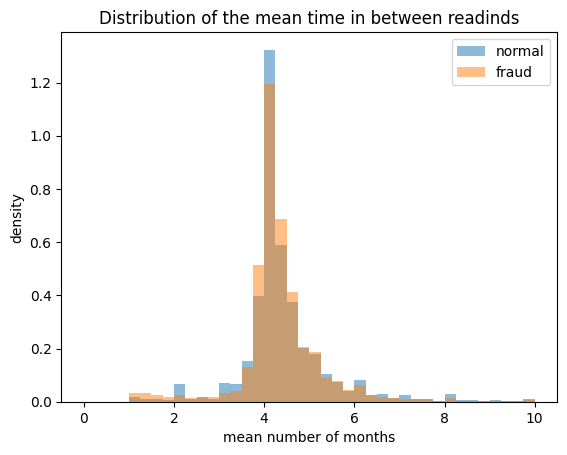

In [51]:
plt.title('Distribution of the mean time in between readinds')
plt.hist(total_consum_normal[total_consum_normal['meter_type'] == 0]['mean_time_between_readings'], density = True, bins = 40, range = (0, 10), label = 'normal', alpha = 0.5)
plt.hist(total_consum_fraud[total_consum_fraud['meter_type'] == 0]['mean_time_between_readings'], density = True, bins = 40, range = (0, 10), label = 'fraud', alpha = 0.5)
plt.ylabel('density')
plt.xlabel('mean number of months')
plt.legend()
plt.show()

The distribution of mean time since last electricty reading are very similar for fraud and normal occurences, hence it is no possible to state that long times between readings influence in an occurence correspond to a fraud or not.

**meter state**

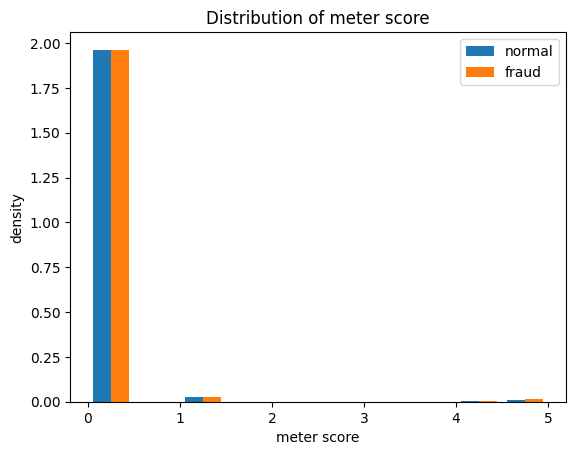

In [72]:
plt.title('Distribution of meter score')
plt.hist([normal_df[normal_df['meter_type'] == 0]['meter_state'], fraud_df[fraud_df['meter_type'] == 0]['meter_state']], label = ['normal', 'fraud'], density = True)
plt.ylabel('density')
plt.xlabel('meter score')
plt.legend()
plt.show()

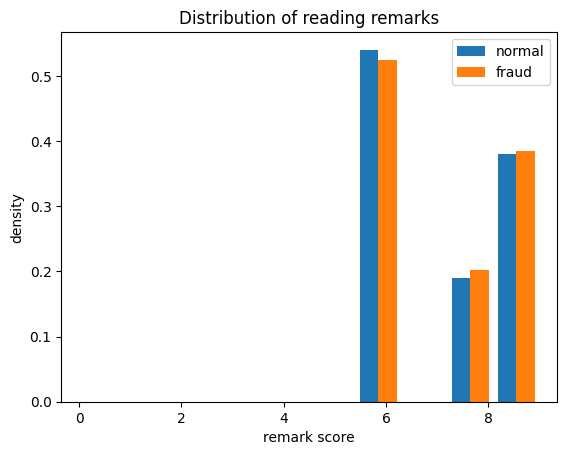

In [73]:
plt.title('Distribution of reading remarks')
plt.hist([normal_df[normal_df['meter_type'] == 0]['reading_remark'], fraud_df[fraud_df['meter_type'] == 0]['reading_remark']], density = True, range = (0, 9), label = ['normal', 'fraud'])
plt.ylabel('density')
plt.xlabel('remark score')
plt.legend()
plt.show()

From the two types of meter scores we cannot really distinguish normal occurences from fraud.

## Feature Engineering

# Modelling

In [ ]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.impute import (
    SimpleImputer,
    KNNImputer
)
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
    PolynomialFeatures,
    KBinsDiscretizer
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

RSEED = 42

Mean value

In [ ]:
cols = mean_fraud_df.columns.tolist()
target = cols.pop(0)
features = cols
features

In [ ]:
X = mean_fraud_df[mean_fraud_df['counter_type'] == 'ELEC'][features].drop(labels=['counter_type', 'mean_consump_band_1', 
                                                                                  'mean_months_number'], axis = 1)
y = mean_fraud_df[mean_fraud_df['counter_type'] == 'ELEC'][target]

In [ ]:
#X['counter_type'] = X['counter_type'].map({'ELEC' : 0, 'GAZ' : 1})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = RSEED, stratify=y)

In [ ]:
fraud_detect_dec_tree = DecisionTreeClassifier(max_depth=9)
fraud_detect_dec_tree.fit(X_train,y_train)
y_pred = fraud_detect_dec_tree.predict(X_test)
print(classification_report(y_test,y_pred))
conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
conf_matrix.plot()
plt.show()

Variance

In [ ]:
var_fraud_df.isnull().sum()

In [ ]:
var_fraud_df.dropna(inplace = True)

In [ ]:
cols = var_fraud_df.columns.tolist()
target = cols.pop(0)
features = cols

In [ ]:
X = var_fraud_df[features]
y = var_fraud_df[target]

In [ ]:
X['counter_type'] = X['counter_type'].map({'ELEC' : 0, 'GAZ' : 1})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = RSEED, stratify=y)

In [ ]:
fraud_detect_dec_tree = DecisionTreeClassifier()
fraud_detect_dec_tree.fit(X_train,y_train)
y_pred = fraud_detect_dec_tree.predict(X_test)
print(classification_report(y_test,y_pred))
conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
conf_matrix.plot()
plt.show()

In [ ]:
fraud_detect_dec_tree = DecisionTreeClassifier()
fraud_detect_dec_tree.fit(X_train[['counter_coefficient']],y_train)
y_pred = fraud_detect_dec_tree.predict(X_test[['counter_coefficient']])
print('Classification report\n', classification_report(y_test,y_pred))
conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
conf_matrix.plot()
plt.show()

## Train LGBM *Classifier*

In [ ]:
x_train = train.drop(columns=['target'])
y_train = train['target']

In [ ]:
model = LGBMClassifier(boosting_type='gbdt', num_iterationss=500)
model.fit(x_train, y_train)

In [ ]:
x_train.disrict.unique()

## Make Predictions on test set

In [ ]:
test.columns

In [ ]:
preds = model.predict(test)
preds = pd.DataFrame(preds, columns=['target'])
preds.head()

In [ ]:
submission = pd.DataFrame(
    {
        'client_id': sub_client_id,
        'target': preds['target']
    }
)

submission.head()

In [ ]:
submission.to_csv(f'{OUTPUT_DIR}/submission.csv', index=False)

## Tips 
- Thorough EDA and incorporating domain knowledge
- Re-grouping categorical features
- More feature engineering(try utilizing some date-time features)
- Target balancing - oversampling, undersampling, SMOTE, scale_pos_weight
- Model ensembling
- Train-test split or cross-validation


# ******************* GOOD LUCK!!! ***************************